In [1]:
from PyPurityTools import PyPurityTools as ppt
from PyPurityFunctions import PyPurityFunctions as ppf
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.signal import savgol_filter
import matplotlib.style
import matplotlib as mpl
import math
import scipy.fftpack
from scipy.signal import butter,filtfilt
import scipy.fftpack
import os
import statistics
import h5py as h5

In [3]:
hf_target_first=h5.File("results_2023_02_02_14_38_smoothed.hdf5","r")
ch4_time=hf_target_first.get('smoothed_ch4_same_plot_100').value
ch3_time=hf_target_first.get('smoothed_ch3_same_plot_100').value
ch3=hf_target_first.get('ave_clean_ch3_smooth_100').value
ch4=hf_target_first.get('ave_clean_ch4_smooth_100').value

In [4]:
#Set default figure size
mpl.rcParams['figure.figsize'] = [15.0, 10.0]
mpl.rcParams["legend.frameon"] = False
mpl.rcParams.update({'font.size': 22})

In [14]:
print(ch3_time)

[    0    10    20 ... 23680 23690 23700]


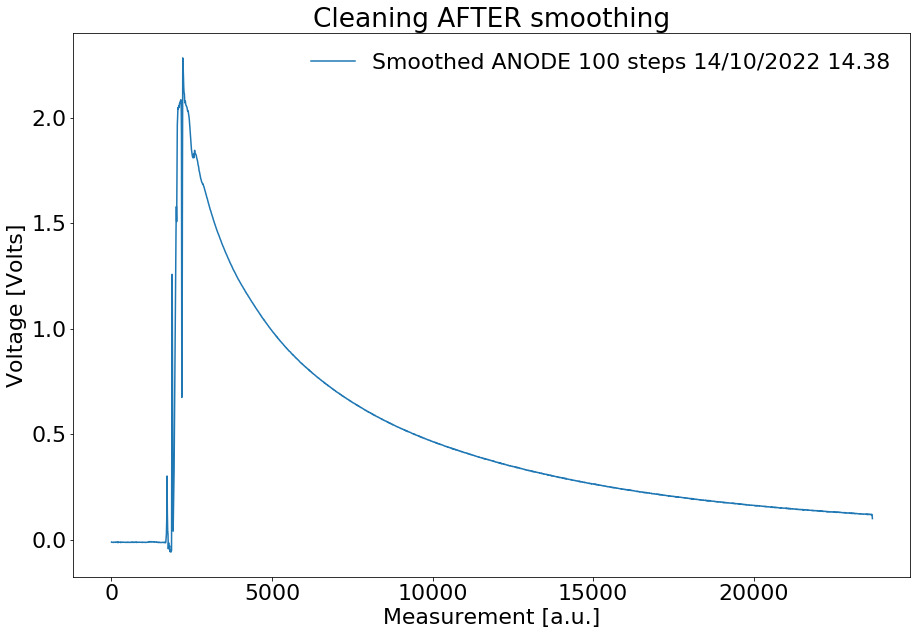

In [9]:
fig, ax = plt.subplots()
ax.plot(ch3_time,ch3,label="Smoothed ANODE 100 steps 14/10/2022 14.38")
ax.set_xlabel("Measurement [a.u.]")
ax.set_ylabel("Voltage [Volts]")
ax.set_title("Cleaning AFTER smoothing")
ax.legend()

In [47]:
import numpy as np

def smooth_waveform(x, y, window_size=3):
    """
    Smooth a waveform using a moving average filter.

    Parameters:
    x (array-like): The x-coordinates of the waveform.
    y (array-like): The y-coordinates of the waveform.
    window_size (int): The size of the moving average window.

    Returns:
    array-like: The smoothed waveform y-coordinates.
    """

    if window_size % 2 == 0:
        # Window size must be odd
        window_size += 1

    # Create the moving average filter
    filter = np.ones(window_size) / window_size

    # Apply the filter to the waveform
    smoothed_y = np.convolve(y, filter, mode='valid')

    # Adjust x-coordinates to match smoothed waveform
    half_window = window_size // 2
    smoothed_x = x[half_window:-half_window]

    return smoothed_x, smoothed_y


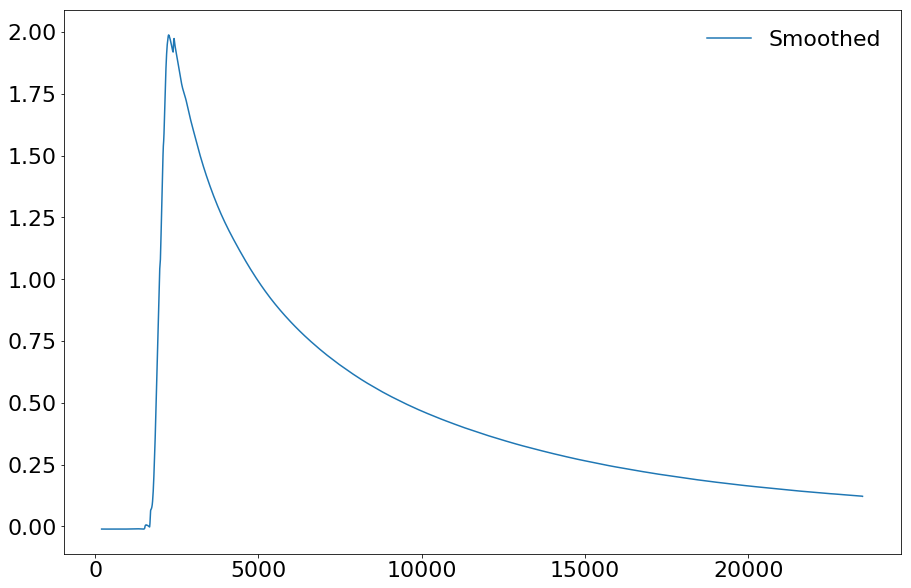

In [67]:
import matplotlib.pyplot as plt

# Generate a noisy waveform
x = ch3_time
y = ch3

# Smooth the waveform
smoothed_x, smoothed_y = smooth_waveform(x, y, window_size=40)

# Plot the original and smoothed waveforms
#plt.plot(x, y, label='Original')
plt.plot(smoothed_x, smoothed_y, label='Smoothed')
plt.legend()
plt.show()


In [68]:
import numpy as np

def find_rising_point(x, y):
    """
    Find the rising point of a waveform.

    Parameters:
    x (array-like): The x-coordinates of the waveform.
    y (array-like): The y-coordinates of the waveform.

    Returns:
    float: The x-coordinate of the rising point, or None if no rising point is found.
    """

    # Validate inputs
    if not isinstance(x, np.ndarray) or not isinstance(y, np.ndarray):
        raise TypeError("Inputs must be numpy arrays.")
    if len(x) != len(y):
        raise ValueError("Inputs must have the same length.")

    # Compute the first derivative of y
    dy = np.gradient(y, x)

    # Find the index of the maximum of the first derivative
    i_max = np.argmax(dy)

    # Check if the waveform is increasing or decreasing
    if dy[i_max] > 0:
        # Find the rising point
        rise_x = np.interp(0, [y[i_max], y[i_max-1]], [x[i_max], x[i_max-1]])
        return rise_x
    elif dy[i_max] < 0:
        # Find the falling point
        fall_x = np.interp(0, [y[i_max], y[i_max+1]], [x[i_max], x[i_max+1]])
        return fall_x

    # If no rising or falling point is found, return None
    return None

In [73]:
def find_peak_position(waveform):
    """
    Find the position of the peak value in a waveform.
    
    Parameters:
        waveform (np.ndarray): A 1D NumPy array representing the waveform.
        
    Returns:
        int: The index of the peak value in the waveform.
    """
    return np.argmax(waveform)

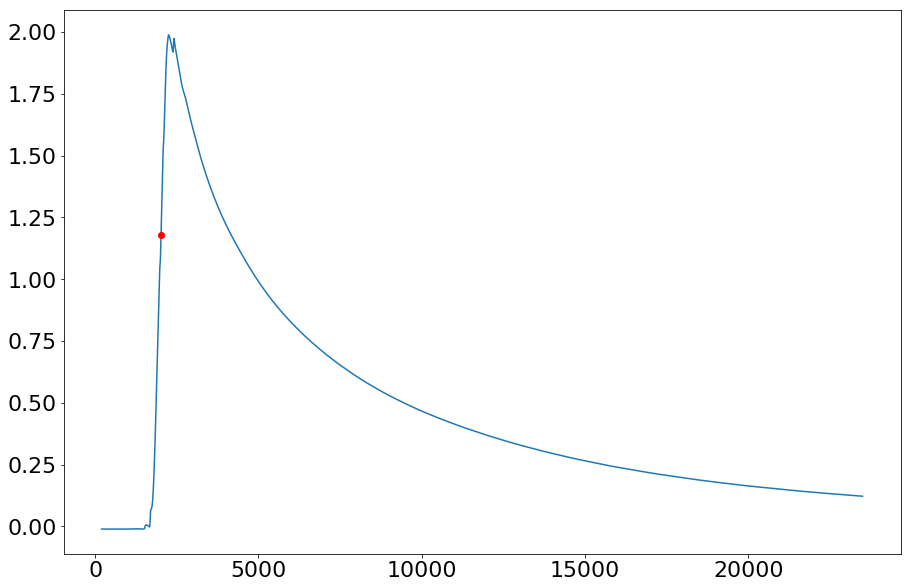

In [76]:
# Find the rising point
rising_point = find_rising_point(smoothed_x, smoothed_y)
peak_position = find_peak_position(smoothed_y)

# Plot the waveform and rising point
import matplotlib.pyplot as plt
plt.plot(smoothed_x, smoothed_y)
if rising_point is not None:
    plt.plot(rising_point, np.interp(rising_point, smoothed_x, smoothed_y), 'ro')
plt.show()

In [77]:
print(peak_position)

205


In [79]:
def plot_waveform(waveform, start_index=0):
    """
    Plot a waveform starting from a given index.
    
    Parameters:
        waveform (np.ndarray): A 1D NumPy array representing the waveform.
        start_index (int): The index to start plotting the waveform from.
            Defaults to 0.
    """
    plt.plot(np.arange(start_index, len(waveform)), waveform[start_index:])
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.show()

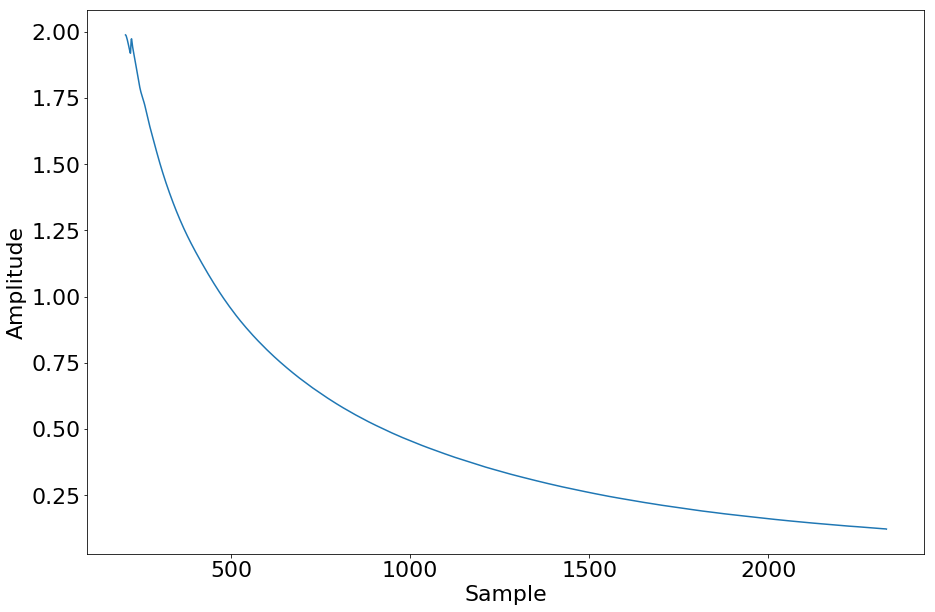

In [80]:
plot_waveform(smoothed_y, start_index=peak_position)

In [81]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def exponential_decay(x, a, b, c):
    """
    Exponential decay function: y = a * exp(-b * x) + c
    
    Parameters:
        x (float): Independent variable.
        a (float): Amplitude parameter.
        b (float): Decay constant parameter.
        c (float): Vertical offset parameter.
        
    Returns:
        float: Dependent variable value at x.
    """
    return a * np.exp(-b * x) + c

def fit_exponential_decay(x_data, y_data):
    """
    Fit an exponential decay function to a set of data points.
    
    Parameters:
        x_data (np.ndarray): 1D NumPy array of independent variable data.
        y_data (np.ndarray): 1D NumPy array of dependent variable data.
        
    Returns:
        tuple: Tuple containing the optimal values for the function parameters and the covariance matrix.
    """
    p0 = (1, 1, 1)  # Initial guess for function parameters
    popt, pcov = curve_fit(exponential_decay, x_data, y_data, p0)
    return popt, pcov

In [ ]:
popt, pcov = fit_exponential_decay(smoothed_x, smoothed_y)
print('Optimal values for function parameters:', popt)

# Plot the original data points and the fitted curve
plt.scatter(smoothed_x, smoothed_y, label='Data')
plt.plot(x_data, exponential_decay(smoothed_x, *popt), label='Fit')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define the fitting function
def waveform_func(x, A, B, C, D, tau, t0):
    return np.piecewise(x, [x <= t0, (x > t0) & (x <= t0 + tau), x > t0 + tau], [A, lambda x: B*(x-t0) + C, lambda x: D*np.exp(-(x-t0-tau)/tau) + B*tau + C])

# Generate example data with three parts: stable, rising, and exponential decay
#x = np.linspace(0, 10, 100)
#y = np.piecewise(x, [x <= 3, (x > 3) & (x <= 6), x > 6], [1, lambda x: 2 * (x - 3) + 1, lambda x: 4 * np.exp(-0.5 * (x - 6)) + 5])


# Find the point where the rising part starts
x_start, y_start = find_rising_start(ch3_time, ch3)

# Fit the rising part of the waveform data with the custom function
x_rising = ch3_time[ch3_time >= x_start]
y_rising = ch3[ch3_time >= x_start]
params_rising = fit_waveform(x_rising, y_rising)
# Calculate the half-life of the exponential decay part
half_life = np.log(2) / popt[4]

# Print the half-life value
print("Half-life: {:.3f}".format(half_life))

# Generate new data to plot the waveform and fitted function
x_plot = np.linspace(0, 10, 1000)
y_plot = waveform_func(x_plot, *popt)

# Plot the waveform data and the fitted function
plt.plot(x, y, 'bo', label='Waveform Data')
plt.plot(x_plot, y_plot, 'r-', label='Fitted Function')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()


TypeError: pw_func() takes 2 positional arguments but 4 were given